In [36]:
import tensorflow as tf
from keras import layers, models
import math

In [35]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# opencv
import cv2
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import os
import os

# import glob
import glob

# import random
import random

# import pickle
import pickle

# tensorflow
import tensorflow as tf

# pandas
import pandas as pd

In [50]:
# Define the path to the WIDER Face dataset
dataset_path = 'data/WIDERFace'

# Load the train/test/val image names and annotation files
train_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
test_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_test_filelist.txt')
val_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_val_bbx_gt.txt')
train_images_path = os.path.join(dataset_path, 'WIDER_train')
test_images_path = os.path.join(dataset_path, 'WIDER_test')
val_images_path = os.path.join(dataset_path, 'WIDER_val')

# Training
TRAIN_WIDER_PATH = "data/WIDERFace/WIDER_train/"

# Validation
VAL_WIDER_PATH = "data/WIDERFace/WIDER_val/"

# Testing
TEST_WIDER_PATH = "data/WIDERFace/WIDER_test/"

# Ground Truth
GROUND_TRUTH_PATH = "data/WIDERFace/wider_face_split/"

# Output
OUTPUT_PATH = "data/WIDERFace/output/"

In [58]:

import tensorflow as tf
import numpy as np
import cv2
import os
import hashlib

In [73]:
base_dir = "data/WIDERFace"
     

train_path = os.path.join(base_dir,"WIDER_train")
val_path = os.path.join(base_dir,"WIDER_val")
test_path = os.path.join(base_dir,"WIDER_test")
     

train_images=[]
for directory in os.listdir(train_path):
  sub_directory = os.path.join(train_path,directory)
  train_images.extend(os.listdir(sub_directory))

print("Found {} images for training.".format(len(train_images)))

train_images[:5]

val_images=[]
for directory in os.listdir(val_path):
  sub_directory = os.path.join(val_path,directory)
  val_images.extend(os.listdir(sub_directory))

print("Found {} images for validating.".format(len(val_images)))

print(val_images[:5])

test_images=[]
for directory in os.listdir(test_path):
    sub_directory = os.path.join(test_path,directory)
    test_images.extend(os.listdir(sub_directory))

print("Found {} images for testing.".format(len(test_images)))

annotation_path = os.path.join(base_dir,"wider_face_split")
val_annotation_path = os.path.join(annotation_path,"wider_face_val_bbx_gt.txt")
train_annotation_path = os.path.join(annotation_path,"wider_face_train_bbx_gt.txt")
test_annotation_path = os.path.join(annotation_path,"wider_face_test_filelist.txt")
     

train_annot = []
with open(train_annotation_path) as f:
  for j in range(len(train_images)):
    dir,name = f.readline().split('/')
    dir = dir.split('__')[0]
    dir = os.path.join(train_path,dir)    
    n = int(f.readline().rstrip())
    co_ords=[]
    if n==0:
      co_ord = f.readline().split()
      co_ords.append(co_ord)
    else:
      for i in range(n):
        co_ord = f.readline().split()
        co_ords.append(co_ord)
    train_annot.append({'image':name,'n':n,'co_ords':co_ords, 'path' : dir })

val_annot = []
with open(val_annotation_path) as f:
  for j in range(len(val_images)):
    dir,name = f.readline().split('/')
    dir = dir.split('__')[0]
    dir = os.path.join(val_path,dir)    
    n = int(f.readline().rstrip())
    co_ords=[]
    if n==0:
      co_ord = f.readline().split()
      co_ords.append(co_ord)
    else:
      for i in range(n):
        co_ord = f.readline().split()
        co_ords.append(co_ord)
    val_annot.append({'image':name,'n':n,'co_ords':co_ords, 'path' : dir })




print("catalogued {} images".format(len(train_annot)))
print("catalogued {} images".format(len(val_annot)))


Found 12880 images for training.
Found 3226 images for validating.
['0_Parade_marchingband_1_1004.jpg', '0_Parade_marchingband_1_104.jpg', '0_Parade_marchingband_1_1045.jpg', '0_Parade_marchingband_1_139.jpg', '0_Parade_marchingband_1_147.jpg']
Found 16097 images for testing.
catalogued 12880 images
catalogued 3226 images


In [ ]:
train_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
with open(train_file, 'r') as f:
    lines = f.readlines()

train_data = {}
for i in range(0, len(lines), 2):
    filename = lines[i].strip()
    num_faces = int(lines[i+1].strip())
    if num_faces == 0:
        continue
    boxes = []
    for j in range(num_faces):
        bbox = lines[i+2+j].strip().split()
        x, y, w, h = map(int, bbox)
        boxes.append([x, y, x+w, y+h])
    train_data[filename] = np.array(boxes)


In [75]:
import tensorflow as tf
from keras import layers, models
from keras.applications import VGG16


def create_cnn_sdd_model(input_shape=(300, 300, 3), num_classes=61):
    # Load the VGG16 model as a base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add your own classifier on top of the base model
    x = base_model.output
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # Create a new model with the VGG16 base model and your own classifier
    model = models.Model(inputs=base_model.input, outputs=predictions)

    return model


In [88]:
from keras.applications import mobilenet_v2
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.backend import epsilon

# Define the model architecture
input_shape = (224, 224, 3)
num_classes = 1
base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(lr=1e-4, epsilon=epsilon(), decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


from keras.preprocessing.image import ImageDataGenerator

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Train the model
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[early_stopping])







Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

C:\Users\Harry Parker\AppData\Local\Temp\ipykernel_20364\651551516.py:53: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - 132s 1s/step - loss: -814.2758 - accuracy: 0.0104 - val_loss: -1826.3220 - val_accuracy: 0.0088
Epoch 2/10
100/100 [==============================] - 104s 1s/step - loss: -3014.3162 - accuracy: 0.0060 - val_loss: -4416.3848 - val_accuracy: 0.0094
Epoch 3/10
100/100 [==============================] - 99s 984ms/step - loss: -6162.5127 - accuracy: 0.0103 - val_loss: -7901.8008 - val_accuracy: 0.0075
Epoch 4/10
100/100 [==============================] - 91s 905ms/step - loss: -9922.9346 - accuracy: 0.0081 - val_loss: -12067.9121 - val_accuracy: 0.0094
Epoch 5/10
100/100 [==============================] - 83s 827ms/step - loss: -14303.8447 - accuracy: 0.0128 - val_loss: -16922.8438 - val_accuracy: 0.0088
Epoch 6/10
100/100 [==============================] - 78s 776ms/step - loss: -19902.6094 - accuracy: 0.0119 - val_loss: -22172.0703 - val_accuracy: 0.0100
Epoch 7/10
100/100 [==============================] - 75s 747ms/step - loss: -2636

In [78]:
from keras import optimizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

model = create_cnn_sdd_model()

def lr_schedule(epoch):
    lr = 0.01
    if epoch > 18:
        lr *= 0.1
    elif epoch > 15:
        lr *= 0.5
    elif epoch > 10:
        lr *= 0.8
    print('Learning rate: ', lr)
    return lr

opt = optimizers.Adam(learning_rate=0.0001)
optimizer = SGD(lr=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

lr_scheduler = LearningRateScheduler(lr_schedule)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [79]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

img_height, img_width = 300, 300
batch_size = 32
epochs = 20

# Implement data preprocessing and augmentation techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Create image and annotation generators
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_path, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical')

# Fit the model to the training data and validate on the validation data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[lr_scheduler, early_stopping])


Found 12880 images belonging to 61 classes.
Found 3226 images belonging to 61 classes.
Learning rate:  0.0001
Epoch 1/50
402/402 [==============================] - 2048s 5s/step - loss: 3.4029 - accuracy: 0.2127 - val_loss: 3.2255 - val_accuracy: 0.2494 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 2/50
402/402 [==============================] - 1893s 5s/step - loss: 2.5315 - accuracy: 0.3720 - val_loss: 3.0849 - val_accuracy: 0.2794 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 3/50
402/402 [==============================] - 1901s 5s/step - loss: 2.1335 - accuracy: 0.4685 - val_loss: 3.0414 - val_accuracy: 0.2872 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 4/50
402/402 [==============================] - 1902s 5s/step - loss: 1.8579 - accuracy: 0.5332 - val_loss: 3.0910 - val_accuracy: 0.2881 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 5/50
402/402 [==============================] - 1887s 5s/step - loss: 1.6312 - accuracy: 0.5957 - val_loss: 3.1313 - val_accuracy: 0.2922 - lr: 1.00

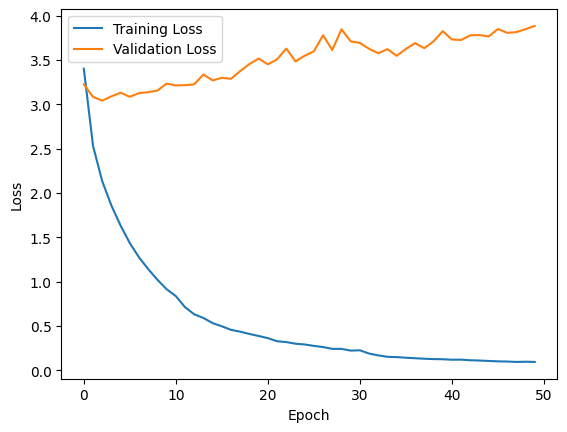

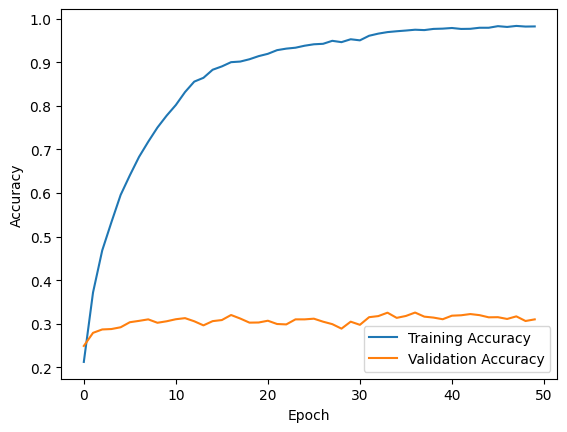

In [81]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from history.history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss over the epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over the epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [82]:
# Evaluate the trained model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
    test_path, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical')
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# Save the trained model and history
model.save('face_detection_model.h5')
history_df = pd.DataFrame(history.history)
history_df.to_csv('face_detection_history.csv', index=False)

Found 16097 images belonging to 61 classes.
503/503 [==============================] - 2350s 5s/step - loss: 3.9355 - accuracy: 0.3104


Found 3226 images belonging to 61 classes.
101/101 [==============================] - 470s 5s/step


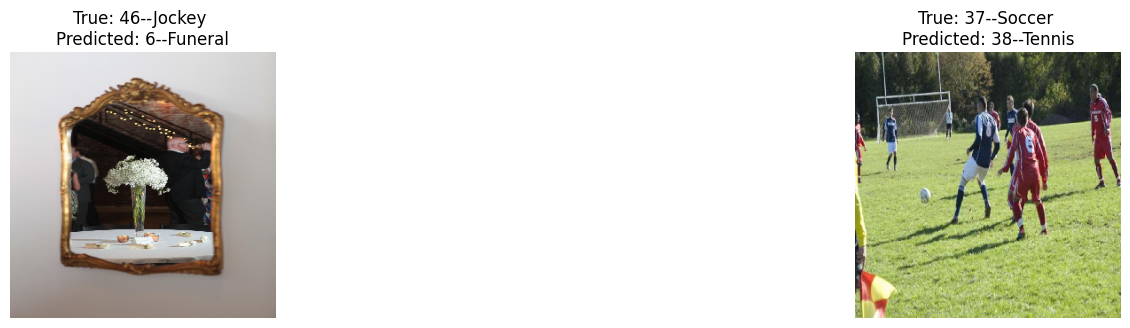

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test set
test_generator = val_datagen.flow_from_directory(
    val_path, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical')

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get a list of class names
class_names = list(train_generator.class_indices.keys())

# Plot some examples with their predicted class labels
num_examples = 2
plt.figure(figsize=(20, 20))
for i in range(num_examples):
    img, true_label = test_generator[i]
    predicted_label = predicted_classes[i]
    plt.subplot(5, 2, i+1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title("True: {} \nPredicted: {}".format(class_names[true_label[0].argmax()], class_names[predicted_label]))
plt.show()


1/1 [==============================] - 1s 728ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

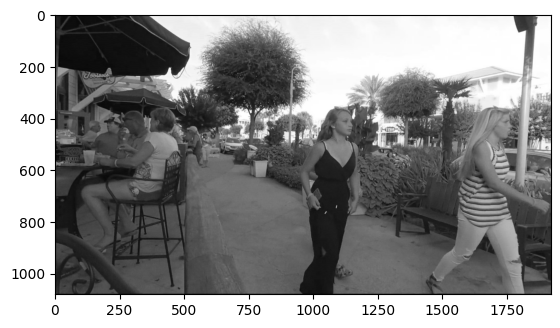

In [85]:
from keras.models import load_model
import cv2
import numpy as np

# Save the trained model as an h5 file
model.save('cnn_sdd_model.h5')

# Load the saved model
model = load_model('face_detection_model.h5')

# Test the model on a new image
img = cv2.imread('./samples/10.jpg')
img = cv2.resize(img, (300, 300))
img = np.expand_dims(img, axis=0)
img = img / 255.0

prediction = model.predict(img)

# Plot the image with the predicted bounding box
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(cv2.imread('./samples/10.jpg'), cv2.COLOR_BGR2RGB))
plt.plot(prediction[0][:, 0], prediction[0][:, 1], 'bo', markersize=2)
plt.show()
